In [1]:
import os, sys

sys.path.append("../")

from data import PollenDataset

In [2]:
data = PollenDataset()

In [3]:
import json

split = json.load(open("../data/splits.json"))

In [4]:
len(data) - len(split["val"]) - len(split["test"])

#len(data)

6603

In [5]:
import os
from collections import Counter

# assuming `split['train']` rows are strings (so row[:5] is already a 5-digit ID)
valid_ids = [row[:5] for row in split['train']]

# list all filenames under "../data/raw/augmented"
augmented = os.listdir("../data/raw/augmented")

# extract the first 5 characters of each augmented-filename as its ID
aug_ids = [fname[:5] for fname in augmented]

# count how many times each ID appears
aug_counts = Counter(aug_ids)

In [6]:
import os
from collections import Counter, defaultdict

# 1) Gather valid IDs from your existing split
valid_ids = [row[:5] for row in split['train']]

# 2) List all augmented filenames
augmented = os.listdir("../data/raw/augmented")

# 3) Define the 7 augmentation names and the 5 magnitudes
aug_list = [
    "full_combo",
    "asymmetry",
    "groove",
    "irregular",
    "radical_reshape",
    "stretching",
    "twisting"
]
magnitudes = [str(i) for i in range(1, 6)]  # ["1", "2", "3", "4", "5"]

# 4) Group all augmented files by their ID (first token before "_")
files_by_id = defaultdict(list)
for fname in augmented:
    # Assume the filename always starts with "<5-digit-ID>_..."
    # If there are any hidden files or non-matching patterns, you might need extra checks.
    file_id = fname.split("_")[0]
    files_by_id[file_id].append(fname)

# 5) For each valid_id, check which (augmentation, magnitude) combinations are missing
missing_per_id = {}  # will map ID → list of (aug_name, magnitude) missing

for vid in valid_ids:
    id_files = files_by_id.get(vid, [])
    missing = []

    # If there are no files at all for this ID, then all 35 combinations are missing
    if not id_files:
        for aug in aug_list:
            for mag in magnitudes:
                missing.append((aug, mag))
        missing_per_id[vid] = missing
        continue

    # Otherwise, for each augmentation name & each magnitude, check presence
    for aug in aug_list:
        for mag in magnitudes:
            found = False
            for fname in id_files:
                # 1) check that "aug" substring is anywhere in the filename
                # 2) check that the final "_" + magnitude is also in the filename
                #    (we look at the last underscore-piece before extension to match magnitude)
                parts = fname.rsplit(".", 1)[0].split("_")
                last_token = parts[-1]  # e.g. "3" if the filename ends in "_3.png"
                if aug in fname and last_token == mag:
                    found = True
                    break
            if not found:
                missing.append((aug, mag))

    if missing:
        missing_per_id[vid] = missing

# 6) Print or inspect the result
for vid, miss_list in missing_per_id.items():
    print(f"ID {vid} is missing {len(miss_list)} files:")
    for aug, mag in miss_list:
        print(f"   • {aug}, magnitude {mag}")
    print()

# Optionally, if you just want a flat list of IDs that don't have the full 35 files:
incomplete_ids = [vid for vid, miss_list in missing_per_id.items() if len(miss_list) > 0]
print(f"\nTotal IDs with incomplete augmentations: {len(incomplete_ids)}")


ID 17817 is missing 35 files:
   • full_combo, magnitude 1
   • full_combo, magnitude 2
   • full_combo, magnitude 3
   • full_combo, magnitude 4
   • full_combo, magnitude 5
   • asymmetry, magnitude 1
   • asymmetry, magnitude 2
   • asymmetry, magnitude 3
   • asymmetry, magnitude 4
   • asymmetry, magnitude 5
   • groove, magnitude 1
   • groove, magnitude 2
   • groove, magnitude 3
   • groove, magnitude 4
   • groove, magnitude 5
   • irregular, magnitude 1
   • irregular, magnitude 2
   • irregular, magnitude 3
   • irregular, magnitude 4
   • irregular, magnitude 5
   • radical_reshape, magnitude 1
   • radical_reshape, magnitude 2
   • radical_reshape, magnitude 3
   • radical_reshape, magnitude 4
   • radical_reshape, magnitude 5
   • stretching, magnitude 1
   • stretching, magnitude 2
   • stretching, magnitude 3
   • stretching, magnitude 4
   • stretching, magnitude 5
   • twisting, magnitude 1
   • twisting, magnitude 2
   • twisting, magnitude 3
   • twisting, magnitude

### Dataset

In [2]:
import os
from typing import List, Tuple

from dotenv import load_dotenv
from PIL import Image
from torch.utils.data import Dataset
import pandas as pd
import torch
import torchvision.transforms as transforms

load_dotenv()

MAX_IMAGES_PER_STRIP = 8

class PollenDataset(Dataset):
    def __init__(
        self,
        image_transforms: transforms.Compose | None = None,
        n_images: int = 2,
        device: torch.device = torch.device("cpu"),
        file_list: List[str] | None = None,
    ):
        if not 1 <= n_images <= MAX_IMAGES_PER_STRIP:
            raise ValueError(
                f"n_images must be in [1, {MAX_IMAGES_PER_STRIP}], got {n_images}"
            )

        self.images_path = os.path.join(os.getenv("DATA_DIR_PATH"), "processed", "images")
        self.voxels_path = os.path.join(os.getenv("DATA_DIR_PATH"), "processed", "voxels")
        self.rotations_csv = os.path.join(os.getenv("DATA_DIR_PATH"), "processed", "rotations.csv")

        self.image_transform = image_transforms
        self.device = device
        self.n_images = n_images

        if file_list is None:
            all_pngs = sorted(
                fname for fname in os.listdir(self.images_path) if fname.lower().endswith(".png")
            )
            self.stems = [png_fname.rsplit(".", 1)[0] for png_fname in all_pngs]
        else:
            self.stems = sorted(file_list)

        self.rotations = pd.read_csv(self.rotations_csv)

    def __len__(self) -> int:
        return len(self.stems)

    def __getitem__(self, idx: int) -> Tuple[Tuple[torch.Tensor, ...], torch.Tensor, torch.Tensor]:
        stem = self.stems[idx]

        strip_path = os.path.join(self.images_path, f"{stem}.png")
        strip_img = Image.open(strip_path).convert("L")
        strip_w, strip_h = strip_img.size

        if strip_w % strip_h != 0:
            raise RuntimeError(
                f"{strip_path} is not an exact grid of squares "
                f"(width {strip_w} px is not a multiple of height {strip_h} px)."
            )

        n_available = strip_w // strip_h
        if self.n_images > n_available:
            raise RuntimeError(
                f"Requested {self.n_images} images but only {n_available} available in strip {stem}."
            )

        to_tensor = transforms.ToTensor()
        patches: list[torch.Tensor] = []

        for i in range(self.n_images):
            left, upper = i * strip_h, 0
            right, lower = left + strip_h, strip_h
            patch_img = strip_img.crop((left, upper, right, lower))

            tensor = (
                self.image_transform(patch_img)
                if self.image_transform
                else to_tensor(patch_img).squeeze(0)
            ).to(torch.float32)

            patches.append(tensor)

        images_tuple: Tuple[torch.Tensor, ...] = tuple(patches)

        df_row = self.rotations.loc[self.rotations["sample"] == stem]
        if df_row.empty:
            raise KeyError(f"No rotation entry found for sample '{stem}' in {self.rotations_csv}")

        rot_x, rot_y, rot_z = map(float, df_row.iloc[0][["rot_x", "rot_y", "rot_z"]])
        rotations = torch.tensor([rot_x, rot_y, rot_z], dtype=torch.float32, device=self.device)

        voxels_path = os.path.join(self.voxels_path, f"{stem}.pt")
        voxels = torch.load(voxels_path)

        return images_tuple, rotations, voxels


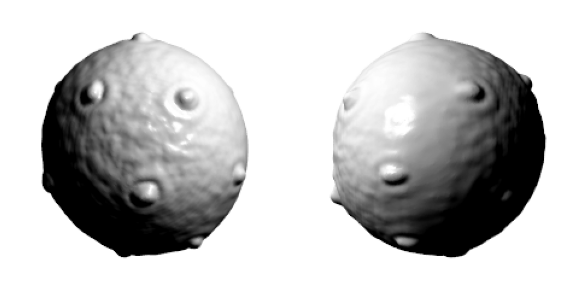

In [10]:
import matplotlib.pyplot as plt

data = PollenDataset(n_images=2)

def plot_images(images: Tuple[torch.Tensor, ...]):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(n * 3, 3))
    for i in range(n):
        ax = axes[i] if n > 1 else axes
        ax.imshow(images[i].cpu().numpy(), cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.show()
    
# Example usage
images, rotations, voxels = data[0]
plot_images(images)

In [7]:
import os
import json
from dotenv import load_dotenv
import torch

load_dotenv()

def make_splits_from_json(
    split_json_path: str,
    image_transforms=None,
    device: torch.device = torch.device("cpu"),
    include_augmentations: bool = True,
) -> tuple[PollenDataset, PollenDataset, PollenDataset]:
    """
    Args:
      split_json_path: path to a JSON containing {"train": [...], "val": [...], "test": [...]}
        where each list contains mesh‐filenames like
          "18227_Ragweed_Ambrosia_sp_pollen_grain_showing_pore_distensions.stl",
          "17885_Peat_moss_Sphagnum_sp_spore.stl", etc.

      image_transforms: torchvision transforms to apply to images
      device: torch.device for storing the rotation tensors
      include_augmentations: 
          - If True: train set = everything in processed/images/ whose first 5 chars match a train ID.
          - If False: train set = only the exact stems from the JSON (no "_aug" suffixes).

    Returns:
      train_dataset, val_dataset, test_dataset (each a PollenDataset restricted to certain stems)
    """
    with open(split_json_path, 'r') as f:
        splits = json.load(f)

    train_list = splits["train"]
    val_list   = splits["val"]
    test_list  = splits["test"]

    train_origins = {fname.split(".")[0] for fname in train_list}
    val_origins   = {fname.split(".")[0] for fname in val_list}
    test_origins  = {fname.split(".")[0] for fname in test_list}

    train_ids_5char = {origin[:5] for origin in train_origins}

    images_dir = os.path.join(os.getenv("DATA_DIR_PATH"), "processed", "images")
    all_pngs = sorted([
        fname for fname in os.listdir(images_dir)
        if fname.lower().endswith(".png")
    ])
    all_stems = [png_fname.rsplit(".", 1)[0] for png_fname in all_pngs]

    if include_augmentations:
        train_stems = [stem for stem in all_stems if stem[:5] in train_ids_5char]
    else:
        train_stems = [stem for stem in all_stems if stem in train_origins]

    val_stems = [stem for stem in all_stems if stem in val_origins]

    test_stems = [stem for stem in all_stems if stem in test_origins]

    train_ds = PollenDataset(
        image_transforms=image_transforms,
        device=device,
        file_list=train_stems
    )
    val_ds = PollenDataset(
        image_transforms=image_transforms,
        device=device,
        file_list=val_stems
    )
    test_ds = PollenDataset(
        image_transforms=image_transforms,
        device=device,
        file_list=test_stems
    )

    return train_ds, val_ds, test_ds


In [44]:
# Suppose you have your own set of transforms and device already defined:
my_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # … etc.
])
device = torch.device("cuda:0")  # or “cpu”

# Path to your JSON file
split_json_path = os.path.join(os.getenv("DATA_DIR_PATH"), "splits.json")

# Create the three splits
train_ds, val_ds, test_ds = make_splits_from_json(
    split_json_path=split_json_path,
    image_transforms=my_transforms,
    include_augmentations=True,
    device=device
)

print(f"Train size: {len(train_ds)}")
print(f"Validation size: {len(val_ds)}")
print(f"Test size: {len(test_ds)}")

Train size: 4633
Validation size: 31
Test size: 32


In [46]:
for sample in train_ds:
    (left_tensor, right_tensor), rotations, voxels = sample
    print(left_tensor.shape, right_tensor.shape, rotations.shape, voxels.shape)

torch.Size([1, 224, 224]) torch.Size([1, 224, 224]) torch.Size([3]) torch.Size([32, 32, 32])
torch.Size([1, 224, 224]) torch.Size([1, 224, 224]) torch.Size([3]) torch.Size([32, 32, 32])
torch.Size([1, 224, 224]) torch.Size([1, 224, 224]) torch.Size([3]) torch.Size([32, 32, 32])
torch.Size([1, 224, 224]) torch.Size([1, 224, 224]) torch.Size([3]) torch.Size([32, 32, 32])
torch.Size([1, 224, 224]) torch.Size([1, 224, 224]) torch.Size([3]) torch.Size([32, 32, 32])
torch.Size([1, 224, 224]) torch.Size([1, 224, 224]) torch.Size([3]) torch.Size([32, 32, 32])
torch.Size([1, 224, 224]) torch.Size([1, 224, 224]) torch.Size([3]) torch.Size([32, 32, 32])
torch.Size([1, 224, 224]) torch.Size([1, 224, 224]) torch.Size([3]) torch.Size([32, 32, 32])
torch.Size([1, 224, 224]) torch.Size([1, 224, 224]) torch.Size([3]) torch.Size([32, 32, 32])
torch.Size([1, 224, 224]) torch.Size([1, 224, 224]) torch.Size([3]) torch.Size([32, 32, 32])
torch.Size([1, 224, 224]) torch.Size([1, 224, 224]) torch.Size([3]) to